# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

#from catboost import CatBoostRegresssor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
259691,2016-04-04 08:56:36,1499,sedan,1996,auto,150,a6,150000,2,petrol,audi,NaN,2016-04-04 00:00:00,0,49086,2016-04-06 10:16:44
240666,2016-03-14 11:25:21,8500,sedan,1984,manual,131,other,100000,2,petrol,fiat,no,2016-03-14 00:00:00,0,65187,2016-04-07 01:46:42
96783,2016-03-07 19:51:13,8488,bus,2006,manual,140,sharan,150000,8,gasoline,volkswagen,no,2016-03-07 00:00:00,0,82515,2016-03-22 04:46:38
166618,2016-03-27 18:52:46,1150,bus,1996,auto,158,grand,150000,3,petrol,chrysler,yes,2016-03-27 00:00:00,0,28203,2016-04-05 17:21:01
10839,2016-03-24 16:45:23,699,small,1997,manual,54,micra,150000,8,petrol,nissan,no,2016-03-24 00:00:00,0,38112,2016-03-24 16:45:23


In [6]:
for i in ['VehicleType','Gearbox','FuelType','Brand']:
    print(f'--{i}({len(df[i].value_counts())}): \n{df[i].value_counts(normalize=True).head(10)} \n')

--VehicleType(8): 
sedan          0.288618
small          0.251929
wagon          0.205649
bus            0.090808
convertible    0.063756
coupe          0.051007
suv            0.037857
other          0.010376
Name: VehicleType, dtype: float64 

--Gearbox(2): 
manual    0.80186
auto      0.19814
Name: Gearbox, dtype: float64 

--FuelType(7): 
petrol      0.673000
gasoline    0.307085
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: FuelType, dtype: float64 

--Brand(40): 
volkswagen       0.217324
opel             0.112682
bmw              0.104168
mercedes_benz    0.090431
audi             0.083122
ford             0.071053
renault          0.050589
peugeot          0.031035
fiat             0.027212
seat             0.019491
Name: Brand, dtype: float64 



В таблице пердставленны данные с марта по апрель 2016 года .
В среднем по 10 тысяч скачивания анкеты в день. 80 процентов автомобилей в данных на механике. Самой распространненой маркой является WV.

In [7]:
pd.pivot_table(df[df['FuelType'].isin(['gasoline','petrol']) ], index='FuelType',values='Price', columns='VehicleType', aggfunc='mean')

VehicleType,bus,convertible,coupe,other,sedan,small,suv,wagon
FuelType,,,,,,,,
gasoline,6238.053847,9513.892430,10354.36087,4191.873706,7010.267774,4185.678534,10319.041147,6282.870891
petrol,4450.236069,6724.541193,5452.39490,3193.697274,3925.848648,2607.236715,7618.754608,3519.680496


Тип топлива petrol и gasoline - это один и тоже бензин но на европейский и американский манер. Но наблюдается разница с средних ценах автомобилей в этих категориях.

Есть пропуски в некоторых признаках , больше всего их в признаке NotRepaired
Для CatBoost это не проблема, для библиотеки они — это отдельная категория.  Но признаки придется кодировать поэтому постараюсь заполнить пропуски или заменить на 'Неизвестно'для категориальных и удалить для числовых. 

Отберу колонки с данными которые явно будут влиять на стоимость автомобиля

'DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen' - даты в этих колонках не могут напрямую влиять на стоимость автомобиля и по ним пргнозировать цену нельзя.

Price	VehicleType	RegistrationYear	Gearbox	Power	Model	Kilometer	RegistrationMonth	FuelType	Brand	NotRepaired

In [8]:
data = df.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)

In [9]:
#data = 

data[((data['VehicleType'].isna()) & (data['Brand'].isna()) & (data['Model'].isna()))].shape

(0, 11)

пропусков одновременно в типе бренде и модели автомобиля нет - попытаемся воставновить пропуски самым частым значением в группах

### Price


In [10]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

<AxesSubplot:>

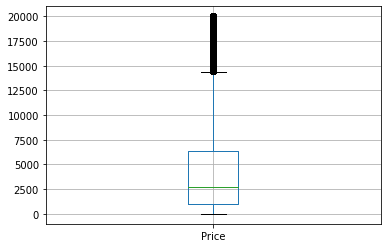

In [11]:
data.boxplot('Price')

<AxesSubplot:>

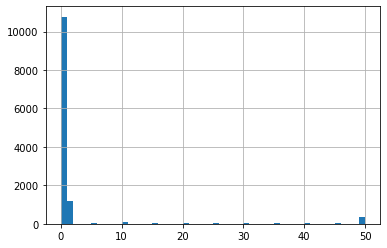

In [12]:
data[ data['Price'] < 51 ]['Price'].hist(bins=50)

In [13]:
len(data[data['Price'] < 10])

12028

Цены 0 быть не должно, такие даные использовать для обучения моделей нельзя - удалим

In [14]:
data = data[~(data['Price'] < 10)]

### VehicleType

In [15]:
data['VehicleType'].value_counts(dropna=False)

sedan          89197
small          77839
wagon          63545
NaN            33249
bus            28280
convertible    19826
coupe          15576
suv            11769
other           3060
Name: VehicleType, dtype: int64

заполню пропуски в колонке частым значением из группы по модели авто 

In [16]:
# data['VehicleType'] = data.groupby(['Brand','Model'])['VehicleType'].apply(lambda x: x.ffill().bfill())
# data['VehicleType'] = data.groupby(['Brand','Model'])['VehicleType'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
data['VehicleType'] = data.groupby(['Brand','Model'])['VehicleType'].apply(lambda x: x.fillna(x.mode().iat[0]))


In [17]:
data[data['VehicleType'].isna()].shape

(17246, 11)

некоторые пропуски заполнили, но не полностью видимо так как в колонке модель много пропусков

### Brand

In [18]:
data['Brand'].value_counts(dropna=False).head()

volkswagen       74169
opel             38368
bmw              35641
mercedes_benz    31249
audi             28481
Name: Brand, dtype: int64

### Model

In [19]:
#data['Model'] = data.groupby(['Brand','VehicleType','RegistrationYear','Power'])['Model'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
data['Model'] = data.groupby(['Brand','VehicleType','RegistrationYear','Power'])['Model'].apply(lambda x: x.fillna(x.mode().iat[0]))

In [20]:
data[data['Model'].isna()]['Price'].count()

17246

Заменять пропуски данным способом довольно  рискованно - но и это практически не дало результата

### Gearbox

In [21]:
data['Gearbox'].value_counts(dropna=False)

manual    260686
auto       64705
NaN        16950
Name: Gearbox, dtype: int64

In [22]:
# data['Gearbox'] = data.groupby(['Brand','Model','Power'])['Gearbox'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan ))
# data['Gearbox'] = data.groupby(['Brand','Model','Power'])['Gearbox'].apply(lambda x: x.ffill().bfill())
# эти способы только ухудшают ситуацию - тажкже заменю пропуски на Unknown

### FuelType

In [23]:
data['FuelType'].value_counts(dropna=False)

petrol      210180
gasoline     96995
NaN          28984
lpg           5155
cng            552
hybrid         226
other          162
electric        87
Name: FuelType, dtype: int64

In [24]:
data['FuelType'] = data.groupby(['VehicleType','Brand','Model'])['FuelType'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

### NotRepaired

In [25]:
data['NotRepaired'].value_counts(dropna=False)

no     243358
NaN     65189
yes     33794
Name: NotRepaired, dtype: int64

In [26]:
data['NotRepaired'] = data['NotRepaired'].fillna('Unknown')

### RegistrationYear

In [27]:
data['RegistrationYear'].describe()

count    342341.000000
mean       2004.074484
std          77.255044
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot:>

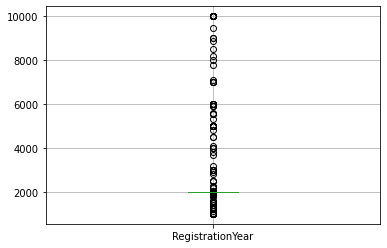

In [28]:
data.boxplot('RegistrationYear')

In [29]:
data[(data['RegistrationYear'] < 1950) | (data['RegistrationYear'] > 2016)].shape

(13873, 11)

пропусков нет но есть неaдекватные даты - считаю что заменить их каким либо годом не целесмообразно - это уменьшит точность предсказаний так как на мой взгляд этот признак очень сильно повлияет на стоимость

In [30]:
data = data[~((data['RegistrationYear'] < 1950) | (data['RegistrationYear'] > 2016))]

еще объединим столбцы года и месяца

In [31]:
data['Reg_date'] = data['RegistrationYear'] + data['RegistrationMonth'] / 100

### Kilometer

In [32]:
data['Kilometer'].describe()

count    328468.000000
mean     128275.265779
std       37398.846212
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

<AxesSubplot:>

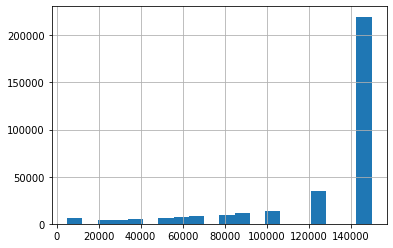

In [33]:
data['Kilometer'].hist(bins=20)

<AxesSubplot:xlabel='Price', ylabel='RegistrationYear'>

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


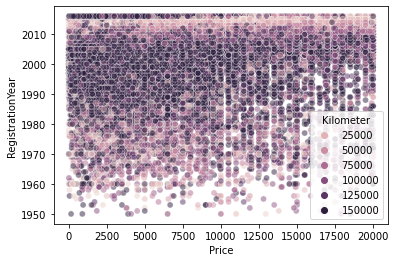

In [34]:
sns.scatterplot(data=data, x='Price',y='RegistrationYear',hue='Kilometer',alpha=0.5)

дата регистрации коррелирует с количеством километров не линейно 

Большое количество анкет с километрожом более 150000км скорее всего из-за отсутсвия возможности поставить значение больше , а у большинства имеено оно было бы больше .

In [35]:
data = data.drop(['RegistrationYear','RegistrationMonth'],axis=1)    

In [36]:
data.corr().head(1)

,Price,Power,Kilometer,Reg_date
Price,1.0,0.16327,-0.357454,0.450416


числовые признаки ожидаемо коррелируют с ценой

In [37]:
# заполню оставшиеся nan 
for i in data.select_dtypes(include=['object']).columns:
    data[i] = data[i].fillna('Unknown')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328468 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Price        328468 non-null  int64  
 1   VehicleType  328468 non-null  object 
 2   Gearbox      328468 non-null  object 
 3   Power        328468 non-null  int64  
 4   Model        328468 non-null  object 
 5   Kilometer    328468 non-null  int64  
 6   FuelType     328468 non-null  object 
 7   Brand        328468 non-null  object 
 8   NotRepaired  328468 non-null  object 
 9   Reg_date     328468 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 27.6+ MB


### Кодирование 

в идеале для порядковых категорий использовать Ordinal, для номинальных - OHE

в нашем случаее все не числовые признаки являются номинальными - соответсвенно придется кодировать OHE хоть это и раздует датафрейм по количеству столбцов и соответсвенно увеличит время работы алгоритма - но даст больше точности.

In [39]:
# data_ohe = pd.get_dummies(data, drop_first=True)
# data_ohe.head()

переведу в категориальный тип 

In [40]:
for i in ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
    data[i] = data[i].astype("category")

In [41]:
enc = OrdinalEncoder()

In [42]:
enc.fit_transform(data.select_dtypes(include=['category']))

array([[  5.,   2., 117.,   7.,  38.,   0.],
       [  0.,   2.,  26.,   0.,   1.,   2.],
       [  7.,   1., 118.,   3.,  14.,   0.],
       ...,
       [  2.,   1., 107.,   7.,  32.,   1.],
       [  1.,   2., 225.,   3.,  38.,   1.],
       [  8.,   2., 117.,   3.,  38.,   0.]])

In [43]:
data_enc = data.copy()

In [44]:
data_enc[data.select_dtypes(include=['category']).columns] = enc.fit_transform(data.select_dtypes(include=['category']))

In [45]:
data_enc.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,Reg_date
0,480,5.0,2.0,0,117.0,150000,7.0,38.0,0.0,1993.00
1,18300,0.0,2.0,190,26.0,125000,0.0,1.0,2.0,2011.05
2,9800,7.0,1.0,163,118.0,125000,3.0,14.0,0.0,2004.08
3,1500,6.0,2.0,75,117.0,150000,7.0,38.0,1.0,2001.06
4,3600,6.0,2.0,69,102.0,90000,3.0,31.0,1.0,2008.07


## Обучение моделей

### Разделение на выборки

In [46]:
np.random.seed(42)

In [47]:
X = data_enc.drop('Price',axis=1)
y = data_enc['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42) 
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(262774, 9) (65694, 9) (262774,) (65694,)


In [48]:
scaler = StandardScaler()

In [49]:
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_valid[X_valid.columns] = scaler.transform(X_valid)

/tmp/ipykernel_24/1180617991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler.fit_transform(X_train)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_24/1180617991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [51]:
# попытка ниписать функции автоматизации сохраниения времени работы обучения и предсказания

name_list = []
time_fit_list = []
time_pred_list = []
rmse_list = []

# def timer_fit(func):
#     def wrapper(*args, **kwargs):
#         start = time.perf_counter()
#         result = func(*args, **kwargs)
#         runtime = time.perf_counter() - start
#         time_fit_list.append(runtime)
#         return result
#     return wrapper

# def timer_pred(func):
#     def wrapper(*args, **kwargs):
#         start = time.perf_counter()
#         result = func(*args, **kwargs)
#         runtime = time.perf_counter() - start
#         time_pred_list.append(runtime)
#         return result
#     return wrapper


### простые модели

Дерево решений

In [52]:
#  работает очень долго

model_tr = DecisionTreeRegressor(random_state=42)
name_list.append('DecisionTreeRegressor')

In [175]:
# parametrs = { #'n_estimators': range (10, 51, 10),
#               'max_depth': range (5,21, 5),
#               'min_samples_leaf': range (2,7,2),
#               'min_samples_split': range (2,7,2) }

# grid = GridSearchCV(model_tr, parametrs, scoring = 'neg_mean_squared_error',  cv=3)
# grid.fit(X, y)

# grid.best_params_

In [202]:
timer_fit(model_tr.fit(X_train,y_train)) 

<function __main__.timer_fit.<locals>.wrapper(*args, **kwargs)>

In [206]:
predict = timer_pred(model_tr.predict(X_valid))

In [ ]:
rmse = mean_squared_error(y_valid, predict, squared=False)
rmse_list.append(rmse)

In [97]:
# tm_fit = time.perf_counter()

# model_tr.fit(X_train,y_train)

# tm_fit = time.perf_counter() - tm_fit
# time_fit_list.append(round(tm_fit,3))

In [161]:
# tm_fit = time.perf_counter()

# predict = model_tr.predict(X_valid)

# tm_fit = time.perf_counter() - tm_fit
# time_fit_list.append(round(tm_fit,3))

In [90]:
# rmse_list.append(mean_squared_error(y_valid,predict, squared=False))

CPU times: user 2.43 ms, sys: 86 µs, total: 2.51 ms
Wall time: 1.49 ms


2364.7037078187923

Случайный лес с лучшими параметрами дерева решений

'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 2

In [218]:
%%time
model_rf = RandomForestRegressor(n_estimators= 200, max_depth=20, min_samples_leaf=6, min_samples_split=2, random_state=42)
model_rf.fit(X_train,y_train)

CPU times: user 1min 56s, sys: 485 ms, total: 1min 56s
Wall time: 1min 56s


RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=200,
                      random_state=42)

In [219]:
%%time
predict = model_rf.predict(X_valid)
rmse = mean_squared_error(y_valid,predict, squared=False) 
rmse

CPU times: user 3.01 s, sys: 7.98 ms, total: 3.02 s
Wall time: 3.03 s


1622.328957324251

### Линейная регрессия

In [216]:
%%time
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

CPU times: user 59.1 ms, sys: 23.7 ms, total: 82.8 ms
Wall time: 63.7 ms


LinearRegression()

In [217]:
%%time
predict = model_lr.predict(X_valid)
rmse = mean_squared_error(y_valid,predict, squared=False)
rmse

CPU times: user 7.65 ms, sys: 27.3 ms, total: 35 ms
Wall time: 7.6 ms


3697.18169744806

### LightGBM

In [117]:
X = data.drop('Price',axis=1)
y = data['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(262774, 9) (65694, 9) (262774,) (65694,)


In [62]:
# %%time
# model_lgbm = LGBMRegressor(objective='rmse', random_state=42)
# param = {
#     'n_estimators': [100,300],
#     'max_depth': [10,15,20],
#     'num_leaves': [100,200],
#     'learning_rate':[0.01 , 0.1, 0.2], 
#     #'boosting_type':[ 'dart', 'goss']
#     }


# grid = GidSearchCV(model_lgbm, param, scoring = 'neg_mean_squared_error',  cv=3)
# grid.fit(X, y)


# pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False).head(3)

In [213]:
model_lgbm = LGBMRegressor(n_estimators=200,
                           max_depth=15, 
                           num_leaves=100, 
                           learning_rate=0.2, 
                           boosting_type='gbdt')

In [214]:
%%time
model_lgbm.fit(X_train,y_train,categorical_feature='auto')

CPU times: user 15.7 s, sys: 86.6 ms, total: 15.8 s
Wall time: 16 s


LGBMRegressor(learning_rate=0.2, max_depth=15, n_estimators=200, num_leaves=100)

In [215]:
%%time
predict = model_lgbm.predict(X_valid)
mean_squared_error(y_valid,predict, squared=False)

CPU times: user 871 ms, sys: 709 µs, total: 872 ms
Wall time: 899 ms


1563.7793777626753

## Анализ моделей

Лучший показатель качества показала модель градиентного бустинга, но она наиболее долго обучается.


In [212]:
pd.DataFrame({'model':['DesTree','RanForest','LinReg','LGBM'],'rsme':[2006,1636,2861,1541],'speed_pred':[1,1,1,1],  'time_fit':[0.1,17,1,36]})

,model,rsme,speed_pred,time_fit
0,DesTree,2006,1,0.1
1,RanForest,1636,1,17.0
2,LinReg,2861,1,1.0
3,LGBM,1541,1,36.0


Ансамблевые модели работают в разы дольше . 

Точность модели на градиентном бустинге во много превосходит остальные модели по метрике качества. Проблемы со скоростью обучения возможно невилировать несколькими подходов к ускорению этого процесса, например:
изменение метода построения дерева, использование облачных вычислений и распределенный XGBoost на лучи(потоки)